# Movielens 영화 SBR
Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작하기

- 데이터의 전처리
- 미니 배치의 구성
- 모델 구성
- 모델 학습
- 모델 테스트

In [1]:
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_12/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 데이터의 전처리
- 간단히 구성해 본 데이터셋을 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행
- SessionId가 없으므로 UserId와 Time을 merge한 뒤에 SessionId를 만든다
- Session Length 각 세션이 몇 편의 영화를 보는지 확인
- Data Cleansing                                                                               
Rating 3정 이상 데이터만 사용
- Train/ Valid/ Test split                                                                 
모델 평가를 위해 데이터에서 마지막 100일을 test set, 그 이전 100일을 validation set으로 나눔

In [3]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
#유저수와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
data_index = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
data_index.reset_index(inplace=True)
data_index

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [6]:
#SessionId 만들기
data=pd.merge(data,data_index,on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.rename(columns={'ItemId_x':'ItemId'}, inplace = True)
data.rename(columns={'index' : 'SessionId'}, inplace = True)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [7]:
#각 세션이 몇 편의 영화를 보는지
session_length = data.groupby('SessionId').size()
session_length  #같은 SessionId를 공유하는 데이터 row의 개수를 의미

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [9]:
session_length.min(), session_length.max()

(1, 30)

In [10]:
session_length.quantile(0.999) #99.9% 세션

10.0

In [11]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

#동시간대에 30편의 영화에 평점을 줌

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [12]:
#세션 길이에 대한 감을 더 잘 파악하기 위해 시각화. 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

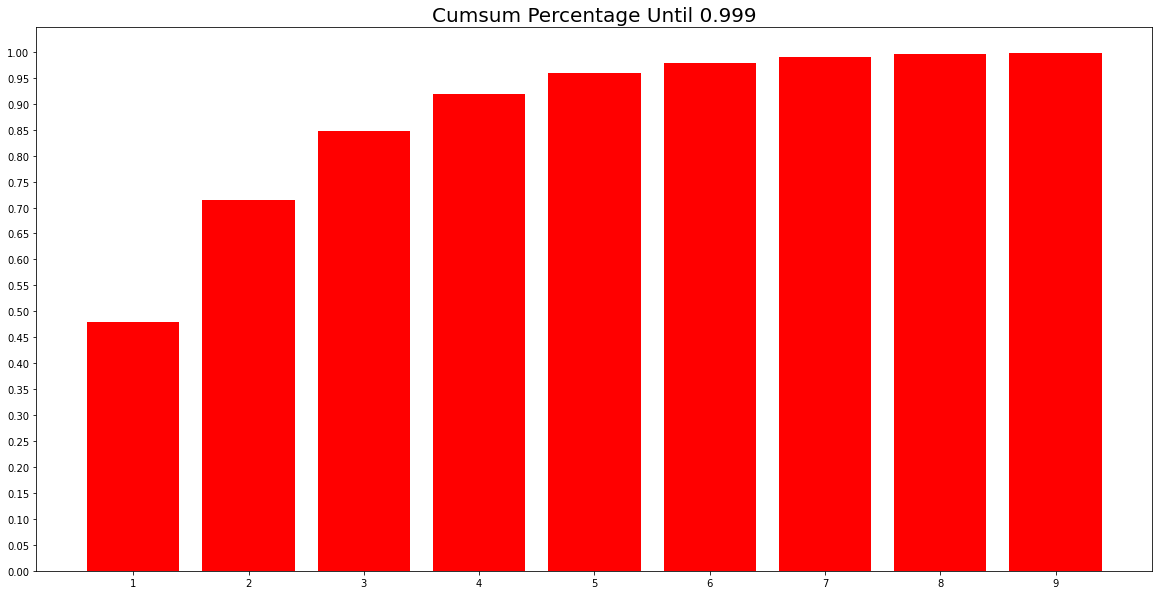

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

#2000/4/25 ~ 2003/2/28

956703932
1046454590


In [15]:
import datetime
#oldest=datetime.datetime.fromtimestamp(oldest)
#print(oldest)

In [16]:
#latest=datetime.datetime.fromtimestamp(latest)
#print(latest)

In [17]:
type(latest)

numpy.int64

In [18]:
#for i in range(len(data['Time'])):
#    data['Time'][i]=datetime.datetime.fromtimestamp(data['Time'][i])    

In [19]:
#data_2000=[s for s in data['Time'] if 2000 in s ]

In [20]:
len(data['Time'])

1000209

In [21]:
data['Time'][0]

978300019

In [22]:
#전체 데이터를 사용
print(len(data[data['Time'] > latest - (86400*365*3)]))  # 최근 3년 데이터 수
print(len(data[data['Time'] > latest - (86400*365*2)]))  # 최근 2년 데이터 수
print(len(data[data['Time'] > latest - (86400*365*1)]))  # 최근 1년 데이터 수

1000209
69349
21704


In [23]:
#3점 이상 데이터만 사용
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [25]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 827992
	 Sessions: 417187
	 Items: 3623
	 First Time : 956703932
	 Last Time : 1029160409

* valid Set Stats Info
	 Events: 4363
	 Sessions: 3146
	 Items: 1727
	 First Time : 1029199206
	 Last Time : 1037810320

* test Set Stats Info
	 Events: 4118
	 Sessions: 3071
	 Items: 1625
	 First Time : 1037824202
	 Last Time : 1046454590



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline
Session-Parallel Mini-Batch구현
- SessionDataset
- SessionDataLoader

In [30]:
##데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [31]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [32]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 827990, 827991, 827992], dtype=int32)

In [33]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 417184, 417185, 417186])

In [34]:
#SessionDataLoader
#SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
#__iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
#mask는 후에 RNN Cell State를 초기화 하는데 사용할 것

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [35]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [36]:
iter_ex = iter(tr_data_loader)

In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## Modeling
1. Evaluation Metric
- precision,recall
- recall@k,Mean Average Precision@k
- 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.MRR과Recall@k를 사용. MRR은 정답 아이템이 나온 순번의 역수 값 
- 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것이다.

2. Model Architecture
3. Model Training
4. Inference

In [38]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [40]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [41]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=40)

In [42]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3623)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      551250    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3623)                184773    
Total params: 736,023
Trainable params: 736,023
Non-trainable params: 0
_________________________________________________________________


In [43]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [44]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.31]

	 - Recall@40 epoch 1: 0.209559
	 - MRR@40    epoch 1: 0.044776



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.57]

	 - Recall@40 epoch 2: 0.274816
	 - MRR@40    epoch 2: 0.064568



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.97]

	 - Recall@40 epoch 3: 0.285846
	 - MRR@40    epoch 3: 0.070099



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.44]

	 - Recall@40 epoch 4: 0.286765
	 - MRR@40    epoch 4: 0.073297



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.41]

	 - Recall@40 epoch 5: 0.289522
	 - MRR@40    epoch 5: 0.074111



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.37]

	 - Recall@40 epoch 6: 0.294118
	 - MRR@40    epoch 6: 0.075165



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.6] 

	 - Recall@40 epoch 7: 0.290441
	 - MRR@40    epoch 7: 0.073488



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.39]

	 - Recall@40 epoch 8: 0.293199
	 - MRR@40    epoch 8: 0.074011



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.43]

	 - Recall@40 epoch 9: 0.292279
	 - MRR@40    epoch 9: 0.075111



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.25] 

	 - Recall@40 epoch 10: 0.289522
	 - MRR@40    epoch 10: 0.074518



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.25]

	 - Recall@40 epoch 11: 0.290441
	 - MRR@40    epoch 11: 0.072443



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.52] 

	 - Recall@40 epoch 12: 0.295037
	 - MRR@40    epoch 12: 0.073191



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.43]

	 - Recall@40 epoch 13: 0.297794
	 - MRR@40    epoch 13: 0.071677



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.37] 

	 - Recall@40 epoch 14: 0.297794
	 - MRR@40    epoch 14: 0.072321



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.22]

	 - Recall@40 epoch 15: 0.288603
	 - MRR@40    epoch 15: 0.071983



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.4]  

	 - Recall@40 epoch 16: 0.284926
	 - MRR@40    epoch 16: 0.071733



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.4] 

	 - Recall@40 epoch 17: 0.287684
	 - MRR@40    epoch 17: 0.071618



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.47]

	 - Recall@40 epoch 18: 0.293199
	 - MRR@40    epoch 18: 0.072487



Train:   0%|          | 0/6418 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.31] 

	 - Recall@40 epoch 19: 0.290441
	 - MRR@40    epoch 19: 0.072674



Evaluation:  89%|████████▉ | 17/19 [00:10<00:01,  1.57it/s]

	 - Recall@40 epoch 20: 0.286765
	 - MRR@40    epoch 20: 0.072586



In [45]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  94%|█████████▍| 15/16 [00:05<00:00,  2.69it/s]

	 - Recall@40: 0.279167
	 - MRR@40: 0.106936



## 결과
### 하이퍼파라미터 튜닝
- batch_size 변경(32~2048까지 조정)
batch_size=2048,1024/drop_rate=0.1, lr=0.001, epochs=20, k=20
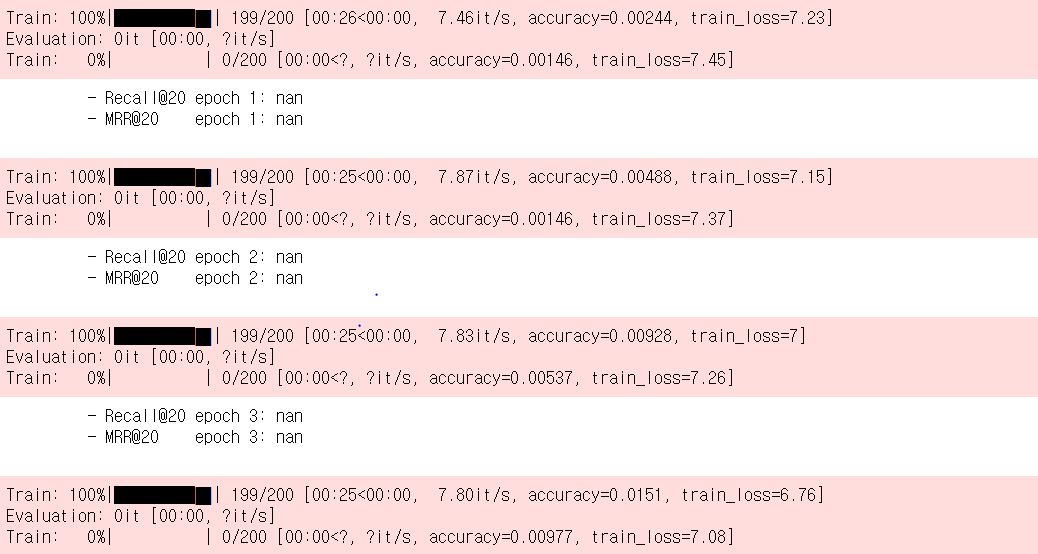
이유는 모르겠지만 Recall@20,MRR@20 모두 NAN 값이 나온다.

batch_size=64/drop_rate=0.1, lr=0.001, epochs=20, k=20

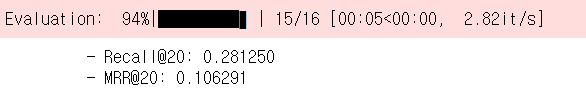
성능이 가장 좋았다.

- k 값 변경(20~40까지 조정)
batch_size=64/drop_rate=0.1, lr=0.001, epochs=20, k=40
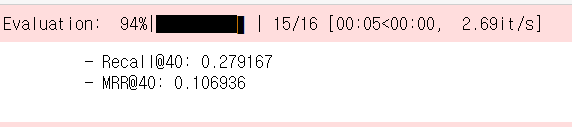

k가 20일때 가장 성능이 좋았다. 결론적으로 k가 커질수록 모델 성능이 더 좋아진다고 했는데 확인해 본 결과 성능이 더 안좋아진 것을 볼 수 있다.